<a href="https://colab.research.google.com/github/xrhd/sandbox/blob/main/GenRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup & Installs

In [1]:
!uv pip install -q -U transformers datasets accelerate peft bitsandbytes trl torch --system

In [2]:
import os
import torch
import transformers
from datasets import load_dataset, Dataset
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from trl import SFTTrainer
import pandas as pd
import re # For basic answer extraction

In [3]:
# # For Gemma: Requires authentication - log in using notebook_login()
# from huggingface_hub import notebook_login
# notebook_login()

import subprocess
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HUGGING_FACE_HUB_TOKEN')
_ = subprocess.run(f'huggingface-cli login --token={os.environ["HF_TOKEN"]}',
               shell=True)

# 2. Configuration

In [4]:
# MODEL_NAME = "google/gemma-3-4b-it" # was "google/gemma-2b"
MODEL_NAME = "google/gemma-2b"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main" # GSM8K specific config

# --- Training Params ---
NUM_TRAIN_EXAMPLES = 200 # Increase slightly for better chance of learning
NUM_EVAL_EXAMPLES = 50
MAX_SEQ_LENGTH = 512 # Max sequence length for tokenizer
LORA_R = 16 # LoRA rank
LORA_ALPHA = 32 # LoRA alpha
LORA_DROPOUT = 0.05
# Gemma target modules might vary, check model config if needed
# Common targets for Gemma-like models:
LORA_TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]

TRAIN_BATCH_SIZE = 1
GRAD_ACCUMULATION_STEPS = 4 # Effective batch size = TRAIN_BATCH_SIZE * GRAD_ACCUMULATION_STEPS
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1 # Train for 1 epoch on the small dataset for PoC
OUTPUT_DIR = "gemma-2b-gsm8k-genrm-poc"
LOGGING_STEPS = 10


# 3. Load Model & Tokenizer (Quantized + LoRA Prep)

In [5]:
# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 # Or float16 if bf16 not supported
)

# Load model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto", # Automatically place layers on devices (GPU/CPU)
    trust_remote_code=True, # Needed for some models
)
model.config.use_cache = False # Required for gradient checkpointing with LoRA

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# Gemma uses BOS but typically no EOS unless manually added during formatting
tokenizer.pad_token = tokenizer.eos_token # Use EOS for padding
tokenizer.padding_side = "right" # Pad right for causal LMs

# Prepare model for k-bit training (important for quantized models)
model = prepare_model_for_kbit_training(model)

# LoRA config
peft_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)

# Add LoRA adapters
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 19,611,648 || all params: 2,525,784,064 || trainable%: 0.7765


# 4. Load & Prepare Dataset

In [6]:
# def extract_final_answer(solution_str):
#     """Simple regex to extract the final numeric answer."""
#     # Look for the last number in the string potentially after "####"
#     match = re.findall(r"####\s*([\d\.\-,]+)", solution_str)
#     if match:
#         return match[-1].replace(',', '') # Return last found number, remove commas
#     # Fallback: find last number in the string
#     match = re.findall(r"[\d\.\-,]+", solution_str)
#     if match:
#         return match[-1].replace(',', '')
#     return None # Cannot find answer

# def create_verification_prompt(question, solution, answer_correctness):
#     """Formats the input for the GenRM Direct verifier."""
#     prompt = f"Question: {question}\n\nSolution: {solution}\n\nIs the final answer correct (Yes/No)? "
#     target = "Yes" if answer_correctness else "No"
#     # Format for SFTTrainer which expects a 'text' column
#     # Add BOS/EOS tokens for Gemma training
#     return f"{tokenizer.bos_token}{prompt}{target}{tokenizer.eos_token}"

# # Load dataset
# dataset = load_dataset(DATASET_NAME, DATASET_CONFIG)

# # --- Create subset and process ---
# train_data = []
# eval_data = []

# print("Processing training data...")
# for i, example in enumerate(dataset['train']):
#     if i >= NUM_TRAIN_EXAMPLES * 2: # Need 2 examples (correct/incorrect) per desired train size
#         break
#     if i % 20 == 0: print(f" Processing train example {i//2+1}/{NUM_TRAIN_EXAMPLES}")

#     question = example['question']
#     ground_truth_solution = example['answer']
#     correct_answer = extract_final_answer(ground_truth_solution)

#     if correct_answer is None:
#         print(f"Warning: Could not extract answer from train example {i}. Skipping.")
#         continue

#     # Example 1: Correct Solution
#     train_data.append({
#         "text": create_verification_prompt(question, ground_truth_solution, True)
#     })

#     # Example 2: Incorrect Solution (Simple modification for PoC)
#     # Let's just change the final number to something obviously wrong like '12345'
#     incorrect_solution_str = re.sub(r"####\s*[\d\.\-,]+", "#### 12345", ground_truth_solution)
#     if incorrect_solution_str == ground_truth_solution: # If regex didn't replace, append error
#          incorrect_solution_str += "\nFinal Answer: The final answer is 12345" # Naive incorrect addition
#     train_data.append({
#         "text": create_verification_prompt(question, incorrect_solution_str, False)
#     })


# print("\nProcessing evaluation data...")
# processed_eval_count = 0
# eval_source_examples = [] # Store original examples for later lookup if needed
# for i, example in enumerate(dataset['test']):
#     if processed_eval_count >= NUM_EVAL_EXAMPLES:
#         break
#     if processed_eval_count % 10 == 0: print(f" Processing eval example {processed_eval_count+1}/{NUM_EVAL_EXAMPLES}")

#     question = example['question']
#     ground_truth_solution = example['answer']
#     correct_answer = extract_final_answer(ground_truth_solution)

#     if correct_answer is None:
#         print(f"Warning: Could not extract answer from test example {i}. Skipping.")
#         continue

#     # Store original for evaluation reference
#     eval_source_examples.append({
#         'question': question,
#         'correct_solution': ground_truth_solution,
#         'incorrect_solution': re.sub(r"####\s*[\d\.\-,]+", "#### 12345", ground_truth_solution) + ("\nFinal Answer: The final answer is 12345" if re.sub(r"####\s*[\d\.\-,]+", "#### 12345", ground_truth_solution) == ground_truth_solution else ""),
#         'is_correct_label_for_correct': True, # Label for the correct one
#         'is_correct_label_for_incorrect': False # Label for the incorrect one
#     })

#     # Add formatted examples for potential SFTTrainer eval (though we'll do manual eval)
#     eval_data.append({"text": create_verification_prompt(question, ground_truth_solution, True)})
#     eval_data.append({"text": create_verification_prompt(question, eval_source_examples[-1]['incorrect_solution'], False)}) # Use generated incorrect sol

#     processed_eval_count += 1


# # Convert to Hugging Face Dataset objects
# train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
# # We don't strictly need eval_dataset for the Trainer if doing manual eval, but good practice
# eval_dataset_for_trainer = Dataset.from_pandas(pd.DataFrame(eval_data))

# print(f"\nPrepared {len(train_dataset)} training examples.")
# print(f"Prepared {len(eval_source_examples)} evaluation examples (each with correct/incorrect pair).")
# print("\nExample Training Text:")
# print(train_dataset[0]['text'])


In [7]:
# Adicione esta importação no início do seu script/célula
import random
import re # Verifique se re foi importado

# ####################################################
# # 4. Load & Prepare Dataset
# ####################################################

# A função extract_final_answer pode permanecer a mesma ou ser ligeiramente melhorada
def extract_final_answer(solution_str):
    """Simple regex to extract the final numeric answer."""
    # Tenta encontrar o padrão #### primeiro
    match = re.findall(r"####\s*([\d\.\-,]+)", solution_str)
    if match:
        # Retorna o último número encontrado após ####, removendo vírgulas
        return match[-1].replace(',', '')
    # Fallback: tenta encontrar o último número na string inteira
    match = re.findall(r"[\d\.\-,]+", solution_str)
    if match:
         # Retorna o último número encontrado, removendo vírgulas
        return match[-1].replace(',', '')
    return None # Não conseguiu encontrar um número

# A função create_verification_prompt permanece a mesma (sem BOS/EOS)
def create_verification_prompt(question, solution, answer_correctness):
    """Formats the input for the GenRM Direct verifier."""
    prompt = f"Question: {question}\n\nSolution: {solution}\n\nIs the final answer correct (Yes/No)? "
    target = "Yes" if answer_correctness else "No"
    return f"{prompt}{target}"

# Load dataset
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG)

# --- Cria subconjunto e processa ---
train_data = []
print("Processing training data...")
processed_train_pairs = 0
source_indices_train = iter(range(len(dataset['train']))) # Iterador para pegar exemplos

while processed_train_pairs < NUM_TRAIN_EXAMPLES:
    try:
        idx = next(source_indices_train)
        example = dataset['train'][idx]
    except StopIteration:
        print("Warning: Ran out of training examples before reaching target.")
        break # Sai do loop se não houver mais exemplos

    if processed_train_pairs % 20 == 0: print(f" Processing train pair {processed_train_pairs+1}/{NUM_TRAIN_EXAMPLES}")

    question = example['question']
    ground_truth_solution = example['answer']
    correct_answer_str = extract_final_answer(ground_truth_solution)

    if correct_answer_str is None:
        continue # Pula se não conseguir extrair a resposta

    # --- INÍCIO DA SEÇÃO MODIFICADA (Geração Aleatória para Treino) ---
    try:
        correct_answer_num = float(correct_answer_str)
    except ValueError:
        correct_answer_num = None # Não pode comparar numericamente

    random_incorrect_answer_num = None
    attempts = 0
    while random_incorrect_answer_num is None or (correct_answer_num is not None and abs(random_incorrect_answer_num - correct_answer_num) < 1e-6) or str(random_incorrect_answer_num) == correct_answer_str:
        if '.' in correct_answer_str: # Se a resposta correta parece ser float
             random_incorrect_answer_num = round(random.uniform(0, 10000) + random.random(), 2)
        else: # Gera inteiro
             random_incorrect_answer_num = random.randint(0, 10000)
        attempts += 1
        if attempts > 10: # Evita loop infinito
             print(f"Warning: Could not generate distinct random number for train example {idx}, using default 99999.")
             random_incorrect_answer_num = 99999
             break
    random_incorrect_answer_str = str(random_incorrect_answer_num)

    # Exemplo 1: Solução Correta (sem alteração na lógica de adição)
    train_data.append({
        "text": create_verification_prompt(question, ground_truth_solution, True)
    })

    # Exemplo 2: Solução Incorreta (com número final aleatório)
    incorrect_solution_str = re.sub(r"####\s*[\d\.\-,]+", f"#### {random_incorrect_answer_str}", ground_truth_solution)
    if incorrect_solution_str == ground_truth_solution:
        matches = list(re.finditer(r"[\d\.\-,]+", ground_truth_solution))
        if matches:
             last_match = matches[-1]
             start, end = last_match.span()
             incorrect_solution_str = ground_truth_solution[:start] + random_incorrect_answer_str + ground_truth_solution[end:]
        else:
             incorrect_solution_str += f"\nFinal Answer: The final answer is {random_incorrect_answer_str}"

    train_data.append({
        "text": create_verification_prompt(question, incorrect_solution_str, False)
    })
    # --- FIM DA SEÇÃO MODIFICADA (Geração Aleatória para Treino) ---
    processed_train_pairs += 1


print("\nProcessing evaluation data...")
eval_source_examples = []
processed_eval_count = 0
source_indices_eval = iter(range(len(dataset['test']))) # Iterador para avaliação

while processed_eval_count < NUM_EVAL_EXAMPLES:
    try:
        idx = next(source_indices_eval)
        example = dataset['test'][idx]
    except StopIteration:
        print("Warning: Ran out of evaluation examples before reaching target.")
        break

    question = example['question']
    ground_truth_solution = example['answer']
    correct_answer_str = extract_final_answer(ground_truth_solution)

    if correct_answer_str is None:
        continue

    # --- INÍCIO DA SEÇÃO MODIFICADA (Geração Aleatória para Avaliação) ---
    try:
        correct_answer_num = float(correct_answer_str)
    except ValueError:
        correct_answer_num = None

    random_incorrect_answer_num = None
    attempts = 0
    while random_incorrect_answer_num is None or (correct_answer_num is not None and abs(random_incorrect_answer_num - correct_answer_num) < 1e-6) or str(random_incorrect_answer_num) == correct_answer_str:
        if '.' in correct_answer_str:
             random_incorrect_answer_num = round(random.uniform(0, 10000) + random.random(), 2)
        else:
             random_incorrect_answer_num = random.randint(0, 10000)
        attempts += 1
        if attempts > 10:
             print(f"Warning: Could not generate distinct random number for eval example {idx}, using default 99999.")
             random_incorrect_answer_num = 99999
             break
    random_incorrect_answer_str = str(random_incorrect_answer_num)

    # Gera a string da solução incorreta
    incorrect_solution_eval = re.sub(r"####\s*[\d\.\-,]+", f"#### {random_incorrect_answer_str}", ground_truth_solution)
    if incorrect_solution_eval == ground_truth_solution:
        matches = list(re.finditer(r"[\d\.\-,]+", ground_truth_solution))
        if matches:
             last_match = matches[-1]
             start, end = last_match.span()
             incorrect_solution_eval = ground_truth_solution[:start] + random_incorrect_answer_str + ground_truth_solution[end:]
        else:
             incorrect_solution_eval += f"\nFinal Answer: The final answer is {random_incorrect_answer_str}"

    # Armazena original para referência na avaliação
    eval_source_examples.append({
        'id': idx,
        'question': question,
        'correct_solution': ground_truth_solution,
        'incorrect_solution': incorrect_solution_eval, # Usa a versão com número aleatório
        'ground_truth_label_for_correct': True,
        'ground_truth_label_for_incorrect': False
    })
    # --- FIM DA SEÇÃO MODIFICADA (Geração Aleatória para Avaliação) ---
    processed_eval_count += 1


# Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
# eval_dataset_for_trainer = Dataset.from_pandas(pd.DataFrame(eval_data)) # Não necessário

# Impressão de informações (sem alterações funcionais)
print(f"\nPrepared {len(train_dataset)} training examples.")
print(f"Prepared {len(eval_source_examples)} evaluation examples.")
if train_dataset:
    print("\nExample Training Text (No manual BOS/EOS):")
    print(train_dataset[0]['text'])
    print("-" * 10)
    print(train_dataset[1]['text']) # Mostra o par correto/incorreto
else:
    print("\nNo training examples generated.")

Processing training data...
 Processing train pair 1/200
 Processing train pair 21/200
 Processing train pair 41/200
 Processing train pair 61/200
 Processing train pair 81/200
 Processing train pair 101/200
 Processing train pair 121/200
 Processing train pair 141/200
 Processing train pair 161/200
 Processing train pair 181/200

Processing evaluation data...

Prepared 400 training examples.
Prepared 50 evaluation examples.

Example Training Text (No manual BOS/EOS):
Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

Solution: Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72

Is the final answer correct (Yes/No)? Yes
----------
Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

So

# 5. Training

In [8]:
from trl import SFTTrainer, SFTConfig # Import SFTConfig

# ####################################################
# # 5. Training
# ####################################################

# Ensure train_dataset is not empty before proceeding
if not train_dataset or len(train_dataset) == 0:
    print("Error: Training dataset is empty. Cannot proceed with training.")
    # Handle the error appropriately, e.g., exit() or raise Exception
else:
    # Training arguments object (remains the same)
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=TRAIN_BATCH_SIZE,
        gradient_accumulation_steps=GRAD_ACCUMULATION_STEPS,
        learning_rate=LEARNING_RATE,
        num_train_epochs=NUM_TRAIN_EPOCHS,
        logging_steps=LOGGING_STEPS,
        optim="paged_adamw_8bit",
        save_strategy="epoch",
        fp16=False,
        bf16=torch.cuda.is_bf16_supported(),
        max_grad_norm=0.3,
        warmup_ratio=0.03,
        lr_scheduler_type="constant",
        report_to="none",
    )

    # SFT Trainer - CORRECTED INITIALIZATION YET AGAIN
    # We remove max_seq_length and dataset_text_field as direct arguments.
    # dataset_text_field defaults to "text", which is correct for us.
    # max_seq_length for truncation/packing is typically handled via SFTConfig/TrainingArguments,
    # but removing it here should let the tokenizer handle truncation based on model max length.
    trainer = SFTTrainer(
        model=model,
        args=training_args, # Pass the TrainingArguments object
        train_dataset=train_dataset,
        peft_config=peft_config,
        processing_class=tokenizer, # Pass tokenizer via processing_class
        # max_seq_length=MAX_SEQ_LENGTH, # <-- REMOVED UNEXPECTED ARGUMENT
        # dataset_text_field="text", # <-- REMOVED (default is 'text')
    )

    # Check GPU memory before training (optional)
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.1f} MB")
        print(f"GPU Memory Reserved:  {torch.cuda.memory_reserved(0)/1024**2:.1f} MB")

    print("\nStarting training...")
    # Train the model
    trainer.train()
    print("Training finished.")

    # Save the final LoRA adapter
    # Ensure the output directory exists
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    trainer.save_model(OUTPUT_DIR)
    print(f"LoRA adapters saved to {OUTPUT_DIR}")

    # Optional: Clean up memory after training if needed before evaluation
    # Note: Variables needed for evaluation (like tokenizer, OUTPUT_DIR) should not be deleted here
    # del model
    # del trainer
    # torch.cuda.empty_cache()

Converting train dataset to ChatML:   0%|          | 0/400 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


GPU Memory Allocated: 3138.3 MB
GPU Memory Reserved:  4204.0 MB

Starting training...


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.465400
20,1.310000
30,1.297400
40,1.166800
50,1.074700
60,1.013700
70,0.957400
80,1.013300
90,0.966600
100,0.948900


Training finished.
LoRA adapters saved to gemma-2b-gsm8k-genrm-poc


# 6. Evaluation (Manual RM Accuracy)

In [13]:
print("\n--- Starting Evaluation ---")

# Load the base model again (quantized) and apply the trained LoRA adapter
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
# Load the LoRA adapter
eval_model = PeftModel.from_pretrained(base_model, OUTPUT_DIR)
eval_model = eval_model.eval() # Set to evaluation mode

# Get 'Yes' and 'No' token IDs (important: case-sensitive)
# Need to check the exact tokenization, might include leading space, etc.
# Common practice: check IDs for " Yes" and " No" or just "Yes", "No"
yes_token_id = tokenizer.encode("Yes", add_special_tokens=False)[-1] # Usually last token if multi-token
no_token_id = tokenizer.encode("No", add_special_tokens=False)[-1]
print(f"Token ID for 'Yes': {yes_token_id}")
print(f"Token ID for 'No': {no_token_id}")
# Verify - sometimes it's a different token if there's a space " Yes"
try:
    alt_yes_id = tokenizer.encode(" Yes", add_special_tokens=False)[-1]
    alt_no_id = tokenizer.encode(" No", add_special_tokens=False)[-1]
    print(f"Token ID for ' Yes': {alt_yes_id}")
    print(f"Token ID for ' No': {alt_no_id}")
    # Use the one that's likely generated after the space in the prompt
    if yes_token_id == tokenizer.unk_token_id and alt_yes_id != tokenizer.unk_token_id:
        yes_token_id = alt_yes_id
    if no_token_id == tokenizer.unk_token_id and alt_no_id != tokenizer.unk_token_id:
        no_token_id = alt_no_id
    print(f"Using 'Yes' ID: {yes_token_id}, 'No' ID: {no_token_id}")
except:
     print("Could not get alternate IDs with space.")


def get_yes_probability(question, solution):
    """Calculates P(Yes | prompt) using the trained model."""
    prompt = f"Question: {question}\n\nSolution: {solution}\n\nIs the final answer correct (Yes/No)? "
    inputs = tokenizer(tokenizer.bos_token + prompt, return_tensors="pt", padding=False).to(eval_model.device)

    with torch.no_grad():
        outputs = eval_model(**inputs)
        logits = outputs.logits

    # Get logits for the *last* token position in the input sequence
    last_token_logits = logits[0, -1, :]

    # Get logits for 'Yes' and 'No' tokens
    yes_logit = last_token_logits[yes_token_id]
    no_logit = last_token_logits[no_token_id]

    # Calculate probability using softmax
    probabilities = torch.softmax(torch.tensor([no_logit, yes_logit]), dim=0) # Index 0=No, 1=Yes
    prob_yes = probabilities[1].item()

    return prob_yes

# --- Evaluate on the held-out examples ---
correct_predictions = 0
results = []

for i, example in enumerate(eval_source_examples):
    if i % 5 == 0: print(f" Evaluating example {i+1}/{len(eval_source_examples)}")
    question = example['question']
    correct_solution = example['correct_solution']
    incorrect_solution = example['incorrect_solution']

    prob_yes_for_correct = get_yes_probability(question, correct_solution)
    prob_yes_for_incorrect = get_yes_probability(question, incorrect_solution)

    # RM Accuracy: Check if P(Yes|Correct) > P(Yes|Incorrect)
    # Using >= for tie-breaking, ideally >
    is_correctly_ranked = prob_yes_for_correct >= prob_yes_for_incorrect

    if is_correctly_ranked:
        correct_predictions += 1

    results.append({
        'question': question,
        'P(Yes|Correct)': prob_yes_for_correct,
        'P(Yes|Incorrect)': prob_yes_for_incorrect,
        'Correctly Ranked': is_correctly_ranked
    })

# Calculate final RM Accuracy
rm_accuracy = correct_predictions / len(eval_source_examples)

print("\n--- Evaluation Results ---")
print(f"RM Accuracy (P(Yes|Correct) >= P(Yes|Incorrect)): {rm_accuracy:.4f}")

# Display some example results
results_df = pd.DataFrame(results)
print("\nSample Evaluation Details:")
print(results_df.head())

# Optional: Very basic Best-of-2 check
# This assumes we only generated 1 correct and 1 incorrect candidate
best_of_2_correct = 0
for res in results:
    # If P(Yes|Correct) is higher, we choose the correct solution
    if res['P(Yes|Correct)'] >= res['P(Yes|Incorrect)']:
         best_of_2_correct += 1
    # If P(Yes|Incorrect) is higher, we choose the incorrect one (failure case)
print(f"\nImplied Best-of-2 Accuracy (choosing higher P(Yes)): {best_of_2_correct / len(results):.4f}")

print("\nPoC Finished.")
print("Note: This is a simplified PoC. Performance depends heavily on dataset size, ")
print("candidate quality, hyperparameters, and training duration.")


--- Starting Evaluation ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Token ID for 'Yes': 3553
Token ID for 'No': 1294
Token ID for ' Yes': 6287
Token ID for ' No': 1307
Using 'Yes' ID: 3553, 'No' ID: 1294
 Evaluating example 1/50
 Evaluating example 6/50
 Evaluating example 11/50
 Evaluating example 16/50
 Evaluating example 21/50
 Evaluating example 26/50
 Evaluating example 31/50
 Evaluating example 36/50
 Evaluating example 41/50
 Evaluating example 46/50

--- Evaluation Results ---
RM Accuracy (P(Yes|Correct) >= P(Yes|Incorrect)): 1.0000

Sample Evaluation Details:
                                            question  P(Yes|Correct)  \
0  Janet’s ducks lay 16 eggs per day. She eats th...        0.916504   
1  A robe takes 2 bolts of blue fiber and half th...        0.914551   
2  Josh decides to try flipping a house.  He buys...        0.957031   
3  James decides to run 3 sprints 3 times a week....        0.885742   
4  Every day, Wendi feeds each of her chickens th...        0.939941   

   P(Yes|Incorrect)  Correctly Ranked  
0          0.862793 

In [14]:
results_df

,question,P(Yes|Correct),P(Yes|Incorrect),Correctly Ranked
0,Janet’s ducks lay 16 eggs per day. She eats th...,0.916504,0.862793,True
1,A robe takes 2 bolts of blue fiber and half th...,0.914551,0.872559,True
2,Josh decides to try flipping a house. He buys...,0.957031,0.948242,True
3,James decides to run 3 sprints 3 times a week....,0.885742,0.849609,True
4,"Every day, Wendi feeds each of her chickens th...",0.939941,0.907715,True
5,Kylar went to the store to buy glasses for his...,0.953125,0.940918,True
6,Toulouse has twice as many sheep as Charleston...,0.930664,0.895020,True
7,Carla is downloading a 200 GB file. Normally s...,0.945312,0.938965,True
8,John drives for 3 hours at a speed of 60 mph a...,0.939453,0.910645,True
9,Eliza's rate per hour for the first 40 hours s...,0.952637,0.947754,True


# 7. Report

--- Results DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          50 non-null     object 
 1   P(Yes|Correct)    50 non-null     float64
 2   P(Yes|Incorrect)  50 non-null     float64
 3   Correctly Ranked  50 non-null     bool   
dtypes: bool(1), float64(2), object(1)
memory usage: 1.3+ KB


--- Basic Performance Report ---
Overall RM Accuracy (P(Yes|Correct) >= P(Yes|Incorrect)): 1.0000
Number of Evaluation Examples: 50
Number Correctly Ranked: 50
Number Incorrectly Ranked: 0
------------------------------

--- Descriptive Statistics for P(Yes) ---
Statistics for P(Yes | Correct Solution):
count    50.000000
mean      0.932070
std       0.026399
min       0.852539
25%       0.920044
50%       0.933350
75%       0.953003
max       0.973633
Name: P(Yes|Correct), dtype: float64
--------------------
Statist

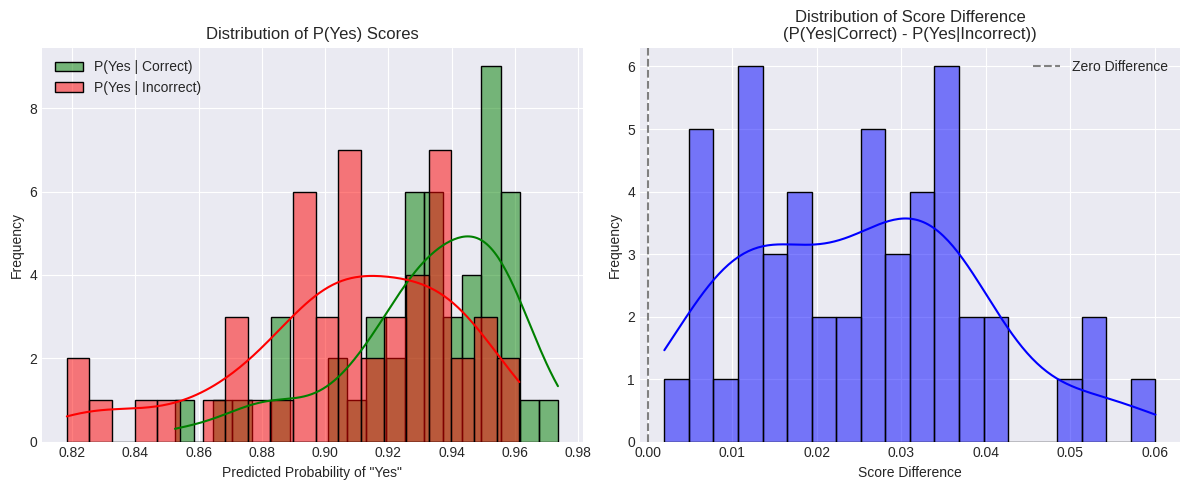

<ipython-input-15-f169ca853abd>:96: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data=results_df, x='P(Yes|Incorrect)', y='P(Yes|Correct)', hue='Correctly Ranked', palette=['red', 'green'])


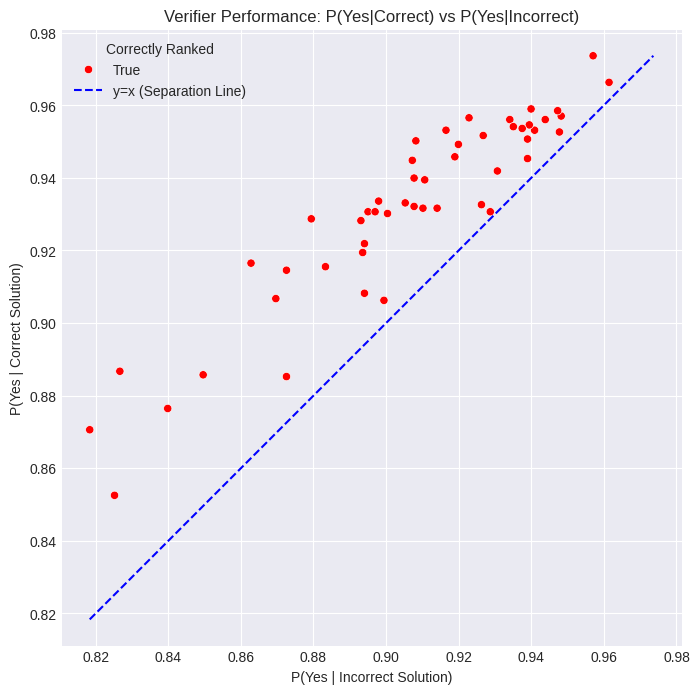


--- Analysis of 0 Incorrectly Ranked Examples ---
Congratulations! All examples were correctly ranked.
------------------------------

--- Analysis of Low Confidence Examples (Score Difference < 0.2) ---

50 examples CORRECTLY ranked but with LOW confidence:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             question  P(Yes|Correct)  P(Yes|Incorrect)  score_diff
25                                                                                                                                              

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
# Adjust this threshold to define what counts as "low confidence" ranking
LOW_CONFIDENCE_THRESHOLD = 0.2

# --- Sanity Check: Ensure results_df exists ---
try:
    # Display basic info to confirm it's loaded
    print("--- Results DataFrame Info ---")
    results_df.info()
    print("\n")
    if not all(col in results_df.columns for col in ['P(Yes|Correct)', 'P(Yes|Incorrect)', 'Correctly Ranked']):
         raise ValueError("results_df is missing required columns: 'P(Yes|Correct)', 'P(Yes|Incorrect)', 'Correctly Ranked'")

except NameError:
    print("Error: 'results_df' not found.")
    print("Please ensure you have run the evaluation section of the previous notebook first,")
    print("or load the results from a saved file (e.g., results_df = pd.read_csv('results.csv')).")
    # Optional: Add code here to load from CSV if needed
    # results_df = pd.read_csv('path/to/your/results.csv') # Example
    # exit() # Or raise error if loading fails

# --- 1. Basic Performance Report ---

print("--- Basic Performance Report ---")

# Overall RM Accuracy (already calculated, but good to restate)
rm_accuracy = results_df['Correctly Ranked'].mean()
print(f"Overall RM Accuracy (P(Yes|Correct) >= P(Yes|Incorrect)): {rm_accuracy:.4f}")
print(f"Number of Evaluation Examples: {len(results_df)}")
print(f"Number Correctly Ranked: {results_df['Correctly Ranked'].sum()}")
print(f"Number Incorrectly Ranked: {len(results_df) - results_df['Correctly Ranked'].sum()}")
print("-" * 30)

# --- 2. Descriptive Statistics of Probabilities ---

print("\n--- Descriptive Statistics for P(Yes) ---")
# Stats for P(Yes | Correct Solution)
print("Statistics for P(Yes | Correct Solution):")
print(results_df['P(Yes|Correct)'].describe())
print("-" * 20)

# Stats for P(Yes | Incorrect Solution)
print("Statistics for P(Yes | Incorrect Solution):")
print(results_df['P(Yes|Incorrect)'].describe())
print("-" * 30)

# --- 3. Score Difference Analysis ---

# Calculate the difference: P(Yes|Correct) - P(Yes|Incorrect)
# A positive difference indicates correct ranking (or better confidence for correct)
results_df['score_diff'] = results_df['P(Yes|Correct)'] - results_df['P(Yes|Incorrect)']

print("\n--- Score Difference (P(Yes|Correct) - P(Yes|Incorrect)) ---")
print("Statistics for Score Difference:")
print(results_df['score_diff'].describe())
print(f"\nPercentage of cases with positive score difference (>0): {(results_df['score_diff'] > 0).mean():.4f}")
print("-" * 30)


# --- 4. Visualizations ---

print("\n--- Generating Visualizations ---")
plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style

# --- Histogram 1: Distribution of P(Yes) Scores ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(results_df['P(Yes|Correct)'], bins=20, kde=True, color='green', label='P(Yes | Correct)')
sns.histplot(results_df['P(Yes|Incorrect)'], bins=20, kde=True, color='red', label='P(Yes | Incorrect)')
plt.title('Distribution of P(Yes) Scores')
plt.xlabel('Predicted Probability of "Yes"')
plt.ylabel('Frequency')
plt.legend()

# --- Histogram 2: Distribution of Score Difference ---
plt.subplot(1, 2, 2)
sns.histplot(results_df['score_diff'], bins=20, kde=True, color='blue')
plt.axvline(0, color='grey', linestyle='--', label='Zero Difference') # Add vertical line at 0
plt.title('Distribution of Score Difference\n(P(Yes|Correct) - P(Yes|Incorrect))')
plt.xlabel('Score Difference')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# --- Scatter Plot: P(Yes|Correct) vs P(Yes|Incorrect) ---
plt.figure(figsize=(8, 8))
sns.scatterplot(data=results_df, x='P(Yes|Incorrect)', y='P(Yes|Correct)', hue='Correctly Ranked', palette=['red', 'green'])

# Add y=x line for reference (perfect separation if all green points are above)
max_val = max(results_df['P(Yes|Correct)'].max(), results_df['P(Yes|Incorrect)'].max())
min_val = min(results_df['P(Yes|Correct)'].min(), results_df['P(Yes|Incorrect)'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='y=x (Separation Line)')

plt.title('Verifier Performance: P(Yes|Correct) vs P(Yes|Incorrect)')
plt.xlabel('P(Yes | Incorrect Solution)')
plt.ylabel('P(Yes | Correct Solution)')
plt.legend(title='Correctly Ranked')
plt.grid(True)
plt.axis('equal') # Ensure equal scaling for x and y axes
plt.show()


# --- 5. Analysis of Incorrectly Ranked Examples ---

incorrectly_ranked_df = results_df[~results_df['Correctly Ranked']].copy() # Use ~ for boolean negation

print(f"\n--- Analysis of {len(incorrectly_ranked_df)} Incorrectly Ranked Examples ---")
if not incorrectly_ranked_df.empty:
    print("Cases where P(Yes|Incorrect) > P(Yes|Correct):")
    # Display relevant columns, sort by how 'wrong' the ranking is (larger negative diff)
    print(incorrectly_ranked_df[['question', 'P(Yes|Correct)', 'P(Yes|Incorrect)', 'score_diff']].sort_values(by='score_diff').to_string())
    # Note: Displaying 'question' assumes it was added during evaluation result saving.
    # If 'question' is not in results_df, remove it from the list above.
else:
    print("Congratulations! All examples were correctly ranked.")
print("-" * 30)


# --- 6. Analysis of Low Confidence Examples ---

# Examples where the ranking was correct, but the difference was small
low_confidence_correct_df = results_df[
    results_df['Correctly Ranked'] & (results_df['score_diff'] < LOW_CONFIDENCE_THRESHOLD)
].copy()

# Examples where the ranking was incorrect (and implicitly low confidence if diff is small)
# We already have incorrectly_ranked_df

print(f"\n--- Analysis of Low Confidence Examples (Score Difference < {LOW_CONFIDENCE_THRESHOLD}) ---")
if not low_confidence_correct_df.empty:
    print(f"\n{len(low_confidence_correct_df)} examples CORRECTLY ranked but with LOW confidence:")
    print(low_confidence_correct_df[['question', 'P(Yes|Correct)', 'P(Yes|Incorrect)', 'score_diff']].sort_values(by='score_diff').to_string())
else:
    print("No correctly ranked examples found with low confidence.")

# You can also check incorrectly ranked examples with small differences
low_conf_incorrect = incorrectly_ranked_df[abs(incorrectly_ranked_df['score_diff']) < LOW_CONFIDENCE_THRESHOLD]
if not low_conf_incorrect.empty:
     print(f"\n{len(low_conf_incorrect)} examples INCORRECTLY ranked and with LOW confidence:")
     print(low_conf_incorrect[['question', 'P(Yes|Correct)', 'P(Yes|Incorrect)', 'score_diff']].sort_values(by='score_diff').to_string())


print("\n--- Reporting Finished ---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          50 non-null     object 
 1   P(Yes|Correct)    50 non-null     float64
 2   P(Yes|Incorrect)  50 non-null     float64
 3   Correctly Ranked  50 non-null     bool   
 4   score_diff        50 non-null     float64
dtypes: bool(1), float64(3), object(1)
memory usage: 1.7+ KB

--- Classification Report ---
                    precision    recall  f1-score   support

Incorrect Solution       1.00      1.00      1.00        50
  Correct Solution       1.00      1.00      1.00        50

          accuracy                           1.00       100
         macro avg       1.00      1.00      1.00       100
      weighted avg       1.00      1.00      1.00       100

------------------------------

--- Confusion Matrix ---


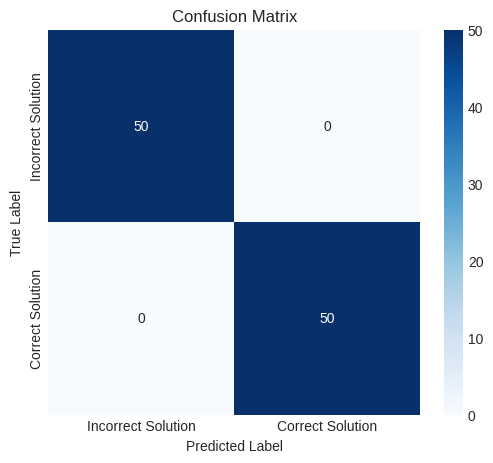

True Negatives (TN): 50 (Correctly predicted 'Incorrect')
False Positives (FP): 0 (Incorrectly predicted 'Correct' when it was 'Incorrect') - Type I Error
False Negatives (FN): 0 (Incorrectly predicted 'Incorrect' when it was 'Correct') - Type II Error
True Positives (TP): 50 (Correctly predicted 'Correct')
------------------------------


In [16]:
# Add necessary imports at the beginning of your script/cell
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Ensure pandas is imported

# --- Configuration ---
# Define the threshold for classifying P(Yes) as a "Yes" prediction

# --- Sanity Check: Ensure results_df exists ---
try:
    results_df.info() # Quick check
    if not all(col in results_df.columns for col in ['P(Yes|Correct)', 'P(Yes|Incorrect)', 'Correctly Ranked']):
         raise ValueError("results_df is missing required columns.")
except NameError:
    print("Error: 'results_df' not found.")
    # Add loading logic if needed
    # exit()

# --- Prepare data for scikit-learn metrics ---

# Predictions for the *actually correct* solutions
is_correct_mask = results_df['P(Yes|Correct)'] >= results_df['P(Yes|Incorrect)']
preds_for_correct = (is_correct_mask).astype(int)
# Ground truth for these is always 1 (they *are* correct)
true_for_correct = np.ones(len(results_df), dtype=int)

# Predictions for the *actually incorrect* solutions
preds_for_incorrect = (~is_correct_mask).astype(int)
# Ground truth for these is always 0 (they *are* incorrect)
true_for_incorrect = np.zeros(len(results_df), dtype=int)

# Combine the ground truth and predictions
y_true_combined = np.concatenate([true_for_correct, true_for_incorrect])
y_pred_combined = np.concatenate([preds_for_correct, preds_for_incorrect])

# Define class names for reporting
target_names = ['Incorrect Solution', 'Correct Solution'] # 0 = Incorrect, 1 = Correct

# --- 7. Scikit-learn Classification Report ---

print(f"\n--- Classification Report ---")
try:
    report = classification_report(y_true_combined, y_pred_combined, target_names=target_names)
    print(report)
except ValueError as e:
    print(f"Could not generate classification report: {e}")
    print("This might happen if one class was never predicted.")
print("-" * 30)


# --- 8. Scikit-learn Confusion Matrix ---

print("\n--- Confusion Matrix ---")
try:
    cm = confusion_matrix(y_true_combined, y_pred_combined)

    # Plotting the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print interpretation
    tn, fp, fn, tp = cm.ravel() # True Negative, False Positive, False Negative, True Positive
    print(f"True Negatives (TN): {tn} (Correctly predicted 'Incorrect')")
    print(f"False Positives (FP): {fp} (Incorrectly predicted 'Correct' when it was 'Incorrect') - Type I Error")
    print(f"False Negatives (FN): {fn} (Incorrectly predicted 'Incorrect' when it was 'Correct') - Type II Error")
    print(f"True Positives (TP): {tp} (Correctly predicted 'Correct')")

except ValueError as e:
    print(f"Could not generate confusion matrix: {e}")
print("-" * 30)


# --- [PREVIOUS REPORTING CODE Sections 1-6 HERE] ---
# Make sure to run the previous sections (Basic Report, Stats, Visualizations, etc.) as well.
# This code block just adds Sections 7 and 8.